# 폐렴아 기다려라!
---

<br>


## 개요
의료 인공지능은 다양한 분야에서 활용되는데, 특히 질병의 정확한 분류 혹은 환자의 중증도를 확인하는 용도 등으로 사용된다.  
이 중에서 현재 가장 핫한 분야는 질병을 탐지해내는 인공지능이며, 이번 프로젝트를 통해 질병을 찾아내는 딥러닝 모델을 만들어보고자 한다.  
이번에 만들 모델은 프로젝트의 제목과 같이 폐렴을 찾아내는 딥러닝 모델을 만드는 것이다.  
폐렴 진단 딥러닝 모델에 사용될 데이터셋은 캐글의 **chest X-Ray Image**이다. 이 데이터셋은 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5세 소아 환자의 흉부 X선 영상이다.  
  
## 목차
1. 폐렴 진단기 만들기  
    1.1. Set-up
        * 모듈 import
        * 전역 변수 생성  
    1.2. 데이터 전처리
        * 데이터 불러오기
        * 데이터 분할
        * 폐렴/정상 데이터 분리
        * 이미지 변환
        * 데이터 준비
    1.3. 데이터 시각화  
    1.4. CNN 모델링  
        * convolution 레이어 정의
        * dense 레이어 정의
        * 모델 빌드
    1.5. 데이터 imbalance 처리  
        * 가중치 부여
    1.6. 모델 훈련  
        * GPU를 사용하여 모델 훈련
    1.7. 결과 확인  
        * 그래프 확인
        * 평가 지표 확인  
2. 폐렴 진단기 성능 개선  
    2.1. Set-up  
        * 전역 변수로 설정된 하이퍼 파라미터 값 변경
    2.2 데이터 전처리  
        * augmentation 기법으로 데이터 증폭
    2.3 데이터 시각화  
    2.4 ResNet-18 구현  
        * Residual block 구성  
    2.5 데이터 imbalance 처리  
    2.6 모델 훈련  
        * GPU를 사용하여 모델 훈련  
    2.7 결과 확인  
        * 그래프 확인
        * 평가 지표 확인
3. 회고
    3.1 Summary
    3.2 KPT

## 페렴진단기 만들기

<br>

<br>

### 1.1. Set-up
---

<br>

#### 모듈 import
* 이번 프로젝트에서 사용할 라이브러리를 import한다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### 전역 변수 생성
* 파일의 경로, 하이퍼 파라미터 등의 미리 고정시켜놓을 변수를 초기화시킨다.

In [2]:
# 빠르게 데이터를 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-Ray 이미지는 180X180 사이즈로 설정
IMAGE_SIZE = [180, 180]

# 데이터 경로 설정
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### 1.2. 데이터 전처리
---

<br>

#### 데이터 불러오기
* 학습, 검증, 평가 데이터를 각각 불러온다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train에는 5,216개의 데이터, test에는 624개의 데이터, val에는 16개의 데이터가 있다.  
개수 비는 89%, 10.7%, 0.3%로 val 개수가 상대적으로 너무 저기 때문에 train에서 데이터를 가져와 val에 추가한다.  
train과 val에 있는 데이터를 합쳐 8:2의 비율로 분할할 것이다.

In [4]:
# train 데이터와 val 데이터 합치기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모은 데이터를 무작위로 섞어서 인덱스 기준 8:2로 분할하여 각 변수에 저장한다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


분할 결과 train 데이터는 4,185개, test 데이터는 624개, val 데이터는 1,047개가 되었다.

#### 폐렴/정상 데이터 분리
* 폐렴과 정상을 구분할 수 있는 기준을 찾아 데이터를 분리시킨다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


파일 경로의 디렉터리명이 NORMAL인지 PNEUMONIA인지를 기준으로 정답 데이터를 추출할 수 있음을 알 수 있다.  
각각의 데이터의 개수를 확인해본다.

In [6]:
# 정상 데이터 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 폐렴 데이터 개수 확인
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 폐렴 이미지 개수가 정상에 비해 약 3배 정도 더 많은 것을 알 수 있다.  
우리가 사용할 CNN 모델의 경우, 데이터가 클래스별 균형이 좋을수록 학습을 잘 학시 때문에 데이터가 클래스 불균형한 것을 차후에 조정할 것이다.  
test와 val은 평가를 위한 데이터이기 때문에 학습과 관련이 없으므로 클래스 불균형한 데이터셋이어도 상관은 없다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없기 때문에 파일 경로를 참고하여 라벨 데이터를 만드는 함수를 정의하도록 한다.

In [9]:
# 폐렴이면 양성(True), 정상이면 음성(False) 라벨을 가지게 된다. 
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

#### 이미지 변환
* 각각의 이미지의 크기가 제각각일 수도 있으므로, GPU 메모리 사용 효율을 위해 이미지의 크기를 하향 평준화시킨다.

In [10]:
def decode_img(img):
    # 이미지 디코드(uint8)
    img = tf.image.decode_jpeg(img, channels=3)
    # 이미지 타입 변환(uint8 -> float32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 이미지 크기 변환(-> 180X180)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def process_path(file_path):
    # 라벨 추출
    label = get_label(file_path)
    # 경로에서 이미지 읽기
    img = tf.io.read_file(file_path)
    # 이미지 변환
    img = decode_img(img)
    return img, label

#### 데이터 준비
* train 데이터셋과 validation 데이터셋을 생성하고, 이 때 AUTOTUNE 변수를 사용하여 데이터 처리를 빠르게 진행한다.

In [27]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# 성능 향상 시도를 위한 변수
train_ds_re = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# 성능 향상 시도를 위한 변수
val_ds_re = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# train 데이터셋 중 한 개의 데이터 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


위에서 지정한대로 데이터의 변환과 라벨 지정이 잘 진행된 180X180 크기의 컬러 정상 이미지인 것을 확인할 수 있다.  
train, validation을 변환한 것과 같이 test 데이터셋도 동일하게 변환해준다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


학습 데이터를 효율적으로 사용하기 위해 tf.data 파이프라인을 사용하여 데이터를 변환시킨다.  
> shuffle()함수를 사용하여 데이터를 무작위로 선택한다.  
> repeat()함수를 사용하여 자동으로 데이터 개수에 맞춰 데이터셋을 반복적으로 불러온다.  
> batch()함수를 사용하여 위에서 지정한 크기만큼의 배치로 나눈다.  
> prefetch()함수를 사용하여 GPU와 CPU의 메모리 사용 효율성을 증가시킨다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 1.3. 데이터 시각화
---
* 데이터를 보기 위해 train에 있는 batch 중 첫 번째 배치를 추출한다.
* 추출된 배치를 image와 label 데이터셋으로 나누고 그 결과를 사진으로 확인한다.

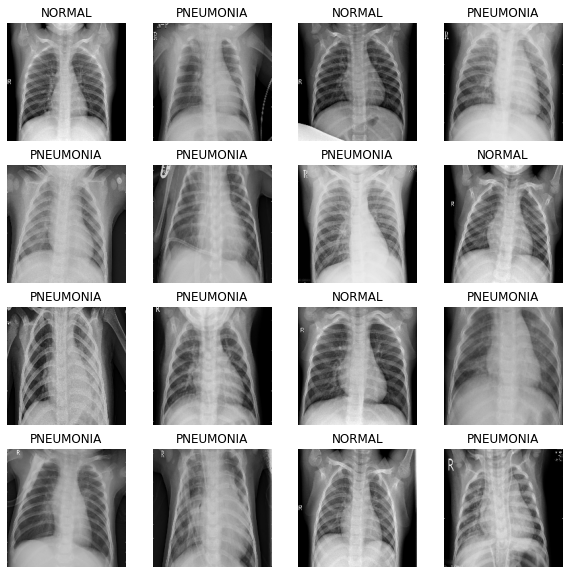

In [15]:
def show_batch(image_batch, label_batch):
    # 그래프 크기
    plt.figure(figsize=(10,10))
    # 배치 크기만큼 반복
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 1.4. CNN 모델링
---

<br>

#### Convolution 레이어 정의
* 모든 레이어를 한 번에 추가하는 기존의 방법과는 달리 Convolution 레이어 블럭을 만드는 함수를 정의한다.  
* 이렇게 만들어진 Convolution 레이어 안에는 두 번의 convolution과 각각 한 번의 배치 정규화와 MaxPooling 레이어가 들어있다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        # 두 번의 convolution 모두 입력 이미지의 크기가 변하지 않는다.
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

#### Dense 레이어 정의
* Dense 블록도 위와 같은 형태로 만들어준다.

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

기존과는 달리 배치정규화 레이어과 드롭아웃 레이어가 붙어 있는 것을 확인할 수 있다.  
논문에 따라 위와 같은 구성을 용인하기도 하고 금기시 하기도 하지만, 두 레이어의 구성이 학습 결과에 미치는 영향을 알아보기 위해 이번 회차에서는 두 레이어를 붙여서 사용하기로 한다.  
* [배치 정규화와 드롭아웃 동시 사용 반대 논문](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)  
* [배치 정규화와 드롭아웃 동시 사용 옹호 논문](https://arxiv.org/pdf/1905.05928.pdf)

#### 모델 빌드
* 위에서 정의한 Conv 블럭과 Dense 블럭을 이용하여 모델을 구성한다.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

모델의 구조는 이 후에 모델을 호출하는 부분에서 확인한다.

### 1.5. 데이터 imbalance 처리
---

<br>

#### 가중치 부여
위에서 확인한 내용과 같이 정상 데이터와 폐렴 데이터의 라벨 비율의 차이가 클 수록 학습 효과가 좋지 않을 수 있다.  
이런 문제들을 해결하는 방법으로 Weight Balancing이라는 기법이 사용되는데, 이는 각 데이터를 계산할 때 특정 클래스에 더 큰 loss값을 갖도록 가중치를 부여하는 방법이다.  
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight에서 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다.  
정상 데이터와 폐렴 데이터에 부여할 가중피는 각 데이터 건수에 반비례하게 설정하도록 한다.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 1.6. 모델 훈련
---

<br>

#### GPU를 사용하는 모델 훈련
* 모델을 훈련하기에 앞서 GPU를 선택하고, 그 뒤에 모델을 훈련시킨다.

In [20]:
with tf.device('/GPU:0'):
    model = build_model()
    model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        # 이진 분류이기 때문에 binary_crossentropy를 사용한다.
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

이제 모델을 학습시킬건데, 각각의 하이퍼 파라미터의 값은 처음 지정했던 전역변수의 값들을 사용하도록 한다.

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 204ms/step - loss: 0.3936 - accuracy: 0.8096 - precision: 0.9530 - recall: 0.7829 - val_loss: 0.6417 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 201ms/step - loss: 0.2111 - accuracy: 0.9217 - precision: 0.9747 - recall: 0.9185 - val_loss: 1.3944 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 201ms/step - loss: 0.2153 - accuracy: 0.9219 - precision: 0.9741 - recall: 0.9196 - val_loss: 0.5786 - val_accuracy: 0.7606 - val_precision: 0.7535 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1863 - accuracy: 0.9313 - precision: 0.9770 - recall: 0.9295 - val_loss: 0.1366 - val_accuracy: 0.9529 - val_precision: 0.9864 - val_recall: 0.9488
Epoch 5/10
261/261 [==============================] - 54s 209ms/step - loss: 0.1462 - accura

### 1.7. 결과 확인
---

<br>

#### 그래프 확인
* 학습 결과를 시각화하여 그래프로 확인한다.

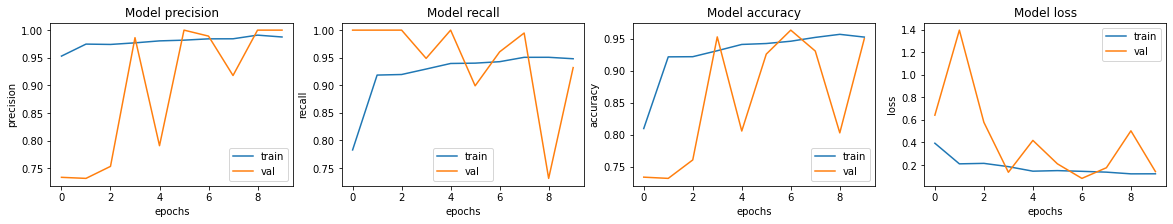

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 평가 지표 확인
* 평가 데이터로 모델을 평가하여 지정한 평가지표를 확인한다.

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 122ms/step - loss: 0.4327 - accuracy: 0.8622 - precision: 0.8378 - recall: 0.9667
Loss: 0.43273866176605225,
Accuracy: 0.8621794581413269,
Precision: 0.8377777934074402,
Recall: 0.9666666388511658


학습 결과 정확도는 95%가 나왔지만, 검증 결과는 86%로 애매한 결과가 나왔다.  
다양한 작업을 통해 폐렴진단기의 성능을 향상시켜보도록 한다.

## 폐렴 진단기 성능 개선

<br>

<br>

### 2.1. Set-up
---

<br>

#### 전역 변수로 설정된 하이퍼 파라미터 값 변경
* 주요 라이브러리의 버전을 확인하고, 하이퍼 파라미터 값들을 변경해본다.

In [24]:
import tensorflow

print(tensorflow.__version__)

2.6.0


현재 사용하고 있는 tensorflow의 버전을 확인한다.
> 현재 최신 버전은 2.15.0이지만, 여러 라이브러리와의 호환성을 고려하여 2.6.0버전을 사용하도록 한다.

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 메모리 사용량 조절을 위해 배치 사이즈를 16에서 8로 변경
BATCH_SIZE = 8
# 메모리 과부하를 대비하여 에폭을 10에서 5로 변경
EPOCHS = 5

GPU 과부하에 대비하여 batch size를 8로, epochs를 일단 줄여놓고 시작한다.

### 2.2. 데이터 전처리
---

#### augumentation 기법으로 데이터 변환
* 데이터가 충분히 많지 않은 경우, 양질의 학습을 진행할 수 있도록 데이터를 변환시켜주는 방법이 있다.
> 유의해야 할 점은, X-Ray 같은 의료 영상의 특성 상 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수 도 있어 해당 기법이 학습에 도움이 될지 방해가 될지 고려해야한다는 것이다.

In [29]:
def augument(image, label):
    # 랜덤하게 좌우반전
    image = tf.image.random_flip_left_right(image)
    # 90도 회전
    image = tf.image.rot90(image)
    
    return image, label

이미지의 노이즈를 증가시키지 않을 법한 기법들로 augumentation을 지정한다.

In [30]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    # augument 함수 적용
    ds = ds.map(augument,num_parallel_calls=2)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# 이 전에 생성해 놓은 변수로 학습/검증 데이터셋 생성
train_ds = prepare_for_training(train_ds_re)
val_ds = prepare_for_training(val_ds_re)

위에서 생성해 놓은 train_ds_re와 val_ds_re 변수에 augumentation이 추가된 배치 처리를 적용한다.

### 2.3. 데이터 시각화
---

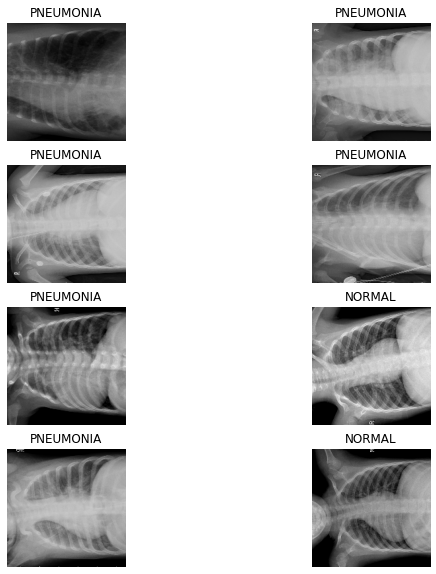

In [31]:
# 학습 데이터의 인덱스를 반복하여 각 이미지/라벨 요소 추출
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

첫 시도와는 다르게 각각의 이미지가 좌우반전/90도 회전이 된 것을 알 수 있다.  
> 출력되는 이미지의 개수는 배치 사이즈 / 4 연산으로 정해지게 되고, 배치 사이즈를 16에서 8로 줄였기 때문에 8개만 출력하게 된다.

### 2.4. ResNet-18 구현
---

<br>

#### Residual block 구성  
ResNet은 2015년 ILSVRC 대회에서 엄청난 성능을 보여준 모델이다.  
ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점이다. ResNet의 residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있다.  
ResNet은 두 개의 Weight Layer와 Skip Connection, relu 활성화 함수를 사용하며, Weight Layer의 구성은 아래와 같다.  
1. 3X3 CNN
2. BatchNormalization
3. 활성화 함수 ReLu

In [68]:
def residual_block(x, filters, strides=1):
    # 첫 번째 합성곱 레이어
    y = tf.keras.layers.SeparableConv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)

    # 두 번째 합성곱 레이어
    y = tf.keras.layers.SeparableConv2D(filters, kernel_size=3, strides=strides, padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)

    # skip connection
    y = tf.keras.layers.concatenate([x, y])

    y = tf.keras.layers.ReLU()(y)

    return y

ResNet-18 모델의 구조를 맞추기 위해 conv_block 함수도 다시 정의하도록 한다.

In [69]:
def conv_block_new(x, filters, strides=1):
    y = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    y = tf.keras.layers.SeparableConv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)

    y = tf.keras.layers.SeparableConv2D(filters, kernel_size=3, strides=1, padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)

    y = tf.keras.layers.concatenate([x, y])

    y = tf.keras.layers.ReLU()(y)

    return y

residual_block과 conv_block_new를 이용하여 요구사항에 맞는 build_resnet함수를 정의하도록 한다.

In [81]:
def build_resnet():
    # input & init
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    x = tf.keras.layers.SeparableConv2D(64, kernel_size=(7,7), strides=2, padding='same')(inputs)

    # conv block 호출
    x = conv_block_new(x, 64)
    
    # residual block 호출
    x = residual_block(x, 128)
    x = residual_block(x, 256)
    x = residual_block(x, 512)

    # 맨 끝 레이어
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name='resnet_model')
    
    return model

In [82]:
from tensorflow.keras.optimizers import Adam

with tf.device('/GPU:0'):
    resnet_model = build_resnet()
    resnet_model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # 학습률 설정
    optimizer = Adam(learning_rate=0.01)
    
    model.compile(
        optimizer=optimizer,
        # 이진 분류이기 때문에 binary_crossentropy를 사용한다.
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "resnet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d_74 (SeparableC (None, 90, 90, 64)   403         input_18[0][0]                   
__________________________________________________________________________________________________
separable_conv2d_75 (SeparableC (None, 90, 90, 64)   4736        separable_conv2d_74[0][0]        
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 90, 90, 64)   256         separable_conv2d_75[0][0]        
_______________________________________________________________________________________

요구되는 모델 구조와 같이 convolution -> maxpooling -> residual -> residual -> residual -> residual -> average pooling -> fully connected 구조로 이루어진 모델을 생성하였다.  
옵티마이져는 Adam 기법을 사용하였고, 학습률을 0.01로 지정하여 훈련 결과를 지켜보도록 한다.

### 2.5. 데이터 imbalance 처리
---
* 데이터의 개수는 변함이 없으므로 위에서 가공한 데이터를 그대로 가져와서 사용한다.

In [83]:
print(class_weight)

{0: 1.955607476635514, 1: 0.6717495987158908}


### 2.6. 모델 훈련
---

<br>

#### GPU를 사용하여 모델 훈련
* 학습 속도를 빠르게하기 위해 GPU를 사용하여 모델을 훈련시킨다.

In [84]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
523/523 [==============================] - 66s 107ms/step - loss: 0.2985 - accuracy: 0.8748 - precision: 0.9599 - recall: 0.8681 - val_loss: 2.2839 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
523/523 [==============================] - 55s 106ms/step - loss: 0.3123 - accuracy: 0.8748 - precision: 0.9602 - recall: 0.8677 - val_loss: 0.1344 - val_accuracy: 0.9510 - val_precision: 0.9696 - val_recall: 0.9632
Epoch 3/5
523/523 [==============================] - 55s 105ms/step - loss: 0.2876 - accuracy: 0.8736 - precision: 0.9668 - recall: 0.8597 - val_loss: 0.1721 - val_accuracy: 0.9327 - val_precision: 0.9819 - val_recall: 0.9253
Epoch 4/5
523/523 [==============================] - 55s 106ms/step - loss: 0.2737 - accuracy: 0.8913 - precision: 0.9723 - recall: 0.8790 - val_loss: 0.1505 - val_accuracy: 0.9433 - val_precision: 0.9770 - val_recall: 0.9450
Epoch 5/5
523/523 [==============================] - 55s 106ms/step - loss: 0.2806 - accuracy: 0

### 2.7. 결과 확인
---

<br>

#### 그래프 확인
* 에폭의 진행에 따른 정밀도, 재현율, 정확도, 손실률을 그래프로 그려 그 변화 추이를 확인한다.

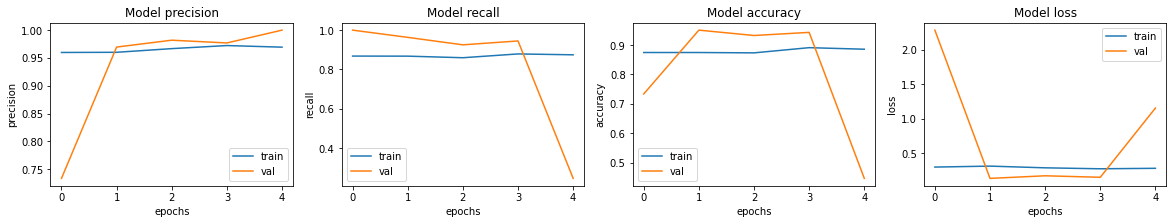

In [85]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 평가 지표 확인
* 평가 데이터로 모델을 평가하여 지정한 평가지표를 확인한다.

In [86]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step - loss: 1.8454 - accuracy: 0.4679 - precision: 0.9531 - recall: 0.1564
Loss: 1.8454006910324097,
Accuracy: 0.46794870495796204,
Precision: 0.953125,
Recall: 0.15641026198863983


정밀도 값만 증가하고 나머지의 성능이 더 떨어졌다...다른 모델로 시도를 해보자.

구글에 서칭을 하다가 심플하게 ResNet-18 모델을 구성하는 subclass 방식을 찾아서 이 방식으로 다시 시도해보자.  
> 참고 사이트: [ResNet-18 모델 구성하기](https://mypark.tistory.com/entry/Tensorflow-2Keras-Week-4-Implementing-ResNet)

In [98]:
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__(name='')
        # residual block에 사용될 레이어의 인스턴스 객체 생성
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, input_tensor):
        # 레이어로 모델 구성
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.add([x, input_tensor])
        x = self.act(x)
        
        return x    


In [99]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        # ResNet-18 모델의 구성 레이어의 인스턴스 객체 생성
        self.conv = tf.keras.layers.Conv2D(128, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))
        self.rd1 = ResidualBlock(128, 3)
        self.rd2 = ResidualBlock(128, 3)
        self.rd3 = ResidualBlock(128, 3)
        self.rd4 = ResidualBlock(128, 3)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='sigmoid')
        
    def call(self, inputs):
        # ResNet-18 모델 구성
        x = self.conv(inputs)
        x = self.act(x)
        x = self.max_pool(x)
        
        x = self.rd1(x)
        x = self.rd2(x)
        x = self.rd3(x)
        x = self.rd4(x)
        
        x = self.global_pool(x)
        
        return self.classifier(x)

모델을 구성하는 데에 사용될 residual block과 ResNet 클래스를 정의한다.

In [102]:
with tf.device('/GPU:0'):
    model = ResNet(1)
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # Adam 옵티마이져의 학습률을 0.05로 설정
    optimizer = Adam(learning_rate=0.05)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[METRICS])

In [103]:
from tensorflow.keras.callbacks import EarlyStopping

with tf.device('/GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(
                train_ds,
                steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                epochs=50,
                validation_data=val_ds,
                validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                class_weight=class_weight,
                callbacks=[early_stopping]
    )

Epoch 1/50
523/523 [==============================] - 65s 107ms/step - loss: 0.6775 - accuracy: 0.7388 - precision: 0.8937 - recall: 0.7367 - val_loss: 0.4969 - val_accuracy: 0.7933 - val_precision: 0.8934 - val_recall: 0.8147
Epoch 2/50
523/523 [==============================] - 55s 105ms/step - loss: 0.4426 - accuracy: 0.8047 - precision: 0.9243 - recall: 0.8035 - val_loss: 0.3676 - val_accuracy: 0.8404 - val_precision: 0.8373 - val_recall: 0.9712
Epoch 3/50
523/523 [==============================] - 56s 106ms/step - loss: 0.3962 - accuracy: 0.8382 - precision: 0.9398 - recall: 0.8363 - val_loss: 0.3942 - val_accuracy: 0.8058 - val_precision: 0.7994 - val_recall: 0.9817
Epoch 4/50
523/523 [==============================] - 55s 105ms/step - loss: 0.3529 - accuracy: 0.8544 - precision: 0.9446 - recall: 0.8545 - val_loss: 0.2617 - val_accuracy: 0.9038 - val_precision: 0.9742 - val_recall: 0.8925
Epoch 5/50
523/523 [==============================] - 57s 108ms/step - loss: 0.2972 - accura

속도가 그렇게 느리지 않아 early stop을 검증 손실의 변화가 3회동안 미비할 때 학습을 조기종료시키는 조건으로 에폭을 50으로 증가시켰다.

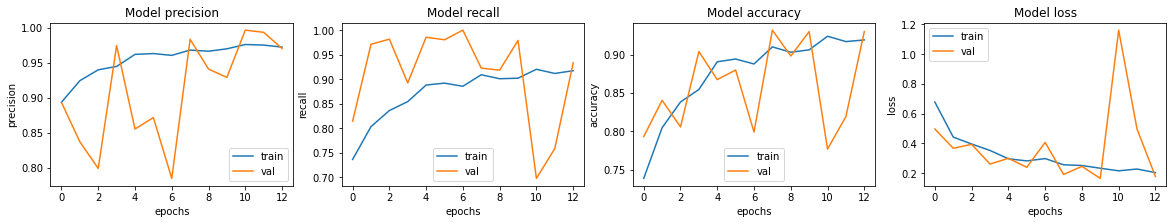

In [104]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [105]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 104ms/step - loss: 0.9242 - accuracy: 0.6683 - precision: 0.8588 - recall: 0.5615
Loss: 0.9242405295372009,
Accuracy: 0.6682692170143127,
Precision: 0.8588235378265381,
Recall: 0.5615384578704834


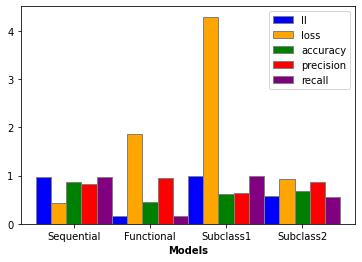

In [107]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Sequential', 'Functional', 'Subclass1', 'Subclass2']
ll_values = [0.97, 0.16, 1.0, 0.57]
loss_values = [0.43, 1.85, 4.29, 0.92]
accuracy_values = [0.86, 0.46, 0.62, 0.67]
precision_values = [0.83, 0.95, 0.63, 0.86]
recall_values = [0.97, 0.16, 1.0, 0.56]

bar_width = 0.2
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

plt.bar(r1, ll_values, color='blue', width=bar_width, edgecolor='grey', label='ll')
plt.bar(r2, loss_values, color='orange', width=bar_width, edgecolor='grey', label='loss')
plt.bar(r3, accuracy_values, color='green', width=bar_width, edgecolor='grey', label='accuracy')
plt.bar(r4, precision_values, color='red', width=bar_width, edgecolor='grey', label='precision')
plt.bar(r5, recall_values, color='purple', width=bar_width, edgecolor='grey', label='recall')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width * 2 for r in range(len(labels))], labels)
plt.legend()

plt.show()


#### 최종 결과
비록 Sequential API를 사용한 모델보다 정확도가 높은 모델을 만들진 못했지만, Subclass API로 구현한 두 번째 ResNet-18 모델은 전체적인 밸런스가 Sequential API 모델보다 좋다는 것을 알 수 있다.

## 회고

<br>

### Summary
---
지금까지 정리한 내용과 같이 **Chest X-Ray Image** 데이터를 활용하여 3가지의 모델을 만들어보았다.
1. Sequential API를 사용한 모델
2. Functional API를 사용한 ResNet-18 모델
3. Subclass API를 사용한 ResNet-18 모델  
각각의 모델의 검증 결과는 다음과 같다.
|   |Sequential|Functional|Subclass1|Subclass2|
|:---:|:---:|:---:|:---:|:---:|
|ll|0.97|0.16|1.0|0.57|
|loss|0.43|1.85|4.29|0.92|
|accuracy|0.86|0.46|0.62|0.67|
|precision|0.83|0.95|0.63|0.86|
|recall|0.97|0.16|1.0|0.56|  

동일한 하이퍼 파라미터 값은 아니었지만(에폭, 학습률, 배치 사이즈 등 수정했음), 그걸 감안하더라도 내가 만든 모델은 성능이 너무 안좋다.  
Subclass API 방식을 좀 더 분석하여 더 균형 있는 결과를 도출할 수 있는 모델을 만들어봐야겠다.  


### KPT
---
#### KEEP
* 각 레이어의 구조를 분석하여 설계하였다.
* 무작위가 아닌 코드를 분석하여 다른 방법을 시도하였다.
#### PROBLEM
* 각 API에 대한 이해가 부족한 상태에서 모델을 구축하였다.
* 결과 값과 하이퍼 파라미터 등의 관계에 대해 파악이 부족하다.
#### TRY
* 사용하고자 하는 API에 대한 개념을 학습한다.
* 각각의 하이퍼 파라미터 값에 대한 결과를 시각화하여 분석한다.